# 4. Regularization

In [1]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
rcParams['figure.figsize'] = (8, 8)
font = {'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)
from IPython.core.display import HTML
css_file = '../my.css'
HTML(open(css_file, "r").read())

Real world data sets such as the ones discussed during the introduction suffer from many shortcomings. One of those is **noise**. **Label noise** is when the true target for a data point is different from the one observed in the data set. This happens for instance when a data set is manually labeled by a field expert (i.e. for the recognition of malignant melanoma). The expert can be wrong for some of the samples. Also, different experts might judge samples differently.

More frequently we observe **noise in the feature values**. Again the true values for the features can differ from the observed values in the data sets. For instance when features are obtained from measuring devices such as microarrays or mass spectrometers. Or when feature values are generated manually by for instance counting or human judgement.

Finally a typical data set will contain many **redundant** or **irrelevant** features. Redundant features are those which provide no more information than other features in the data set, and irrelevant features provide no useful information in any context.

In the **presence of noise the model should not try to fit the data perfectly**. If it does it will be fitting the noise. Similarly, **if we are not sure all features are relevant, the model should not try to use all features**.


Let's illustrate this with a simple polynomial regression example. We will generate a data set that contains 30 data points that were sampled from the function $f(x)=\cos(1.5\pi x)$. Next we add random noise to the target and make polynomial data transformations of varying degrees. Finally we plot the resulting model fits.

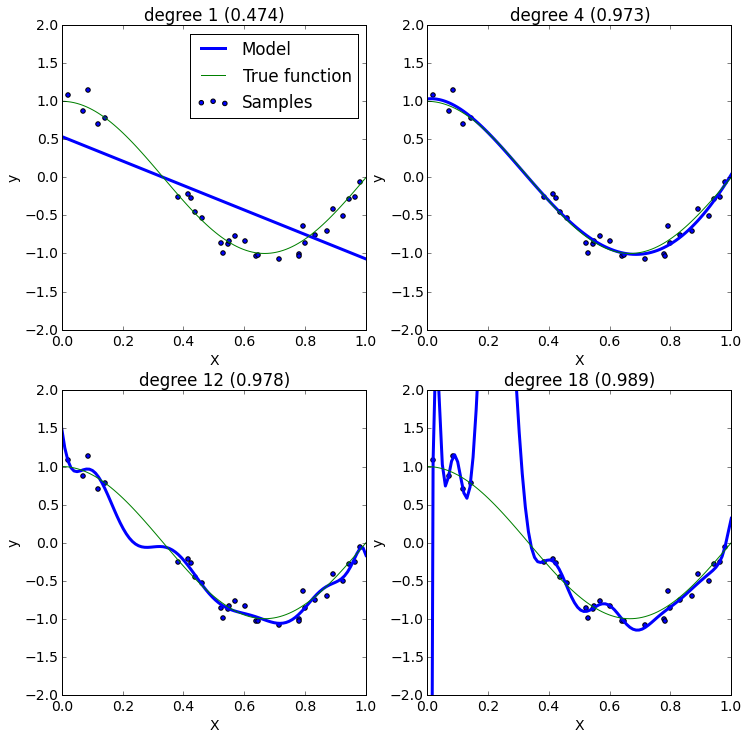

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 12, 18]

true_fun = lambda X: np.cos(1.5 * np.pi * X)

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1 #adding noise

plt.figure(figsize=(12, 12))
for i in range(len(degrees)):
    ax = plt.subplot(2, 2, i+1)
    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    pred = pipeline.predict(X[:, np.newaxis])
    
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model",lw=3)
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    if i == 0: plt.legend(loc="upper right")
    plt.title("degree %d (%.3f)" % (degrees[i],metrics.r2_score(y,pred)))
plt.show()

For each plot the polynomial degree of the model as well as $R^2$ is shown as the title. We observe how $R^2$ becomes better when we increase the degree of the polynomial, i.e. when we increase the complexity of the model. However we can also observe very clearly how the complex models start to fit the noise in the data set and deviate strongly from the true function that generated the data (green curve).

In chapter 2 we have seen how we can avoid overfitting the degree $d$ when using a data set with augmented polynomial features. We used $k$-fold CV to create validation sets. By searching for the optimal value for $d$ using CV we are actually trying to control the **complexity** of the model such that it performs well on both the train **and** the validation set. As the validation set mimics the test set we can expect best generalization performance for the optimal value of $d$ obtained on this validation set.

Controlling the complexity of the model applies to all machine learning algorithms. Consider for instance the following data set separated into two classes by the logistic regression algorithm:

In [3]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

h = 0.2

def create_heatmap(X):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    return np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

def plot_decision_boundary(clf,X,y):
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])   
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

0.84


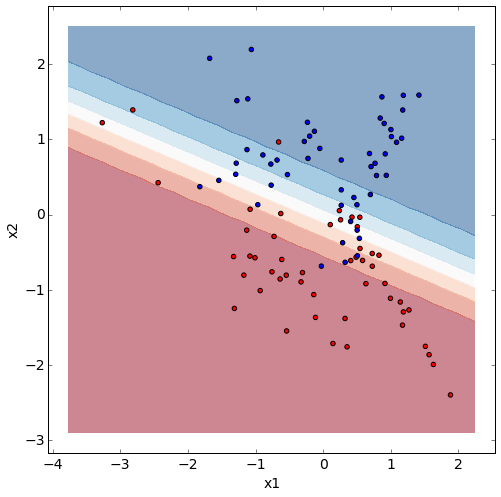

In [4]:
import sklearn.datasets as ds
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

(X,Y)=ds.make_classification(n_samples=100,n_features=2,n_redundant=0,random_state=8)
X = StandardScaler().fit_transform(X)

(xx,yy) = create_heatmap(X)

model = LogisticRegression(C=10000,penalty='l2')
model.fit(X,Y)
score = model.score(X, Y)
print score

plot_decision_boundary(model,X,Y)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

This data can never be separated with 100% accuracy using a linear model. For this model the accuracy on the train set is 84%. However, we can again add polynomial transformations of the features to obtain much better classification accuracy on the train set:

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

clf = LogisticRegression(C=10000,penalty='l2')
polynomial_features = PolynomialFeatures(degree=7)
model = Pipeline([("polynomial_features", polynomial_features),
                         ("logistic_regression", clf)])

model.fit(X,Y)
score = model.score(X, Y)
print score

plot_decision_boundary(model,X,Y)
plt.title('d=7')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

0.97


In this case the accuracy is 92%. However, as with the example of regression discussed above we can again observe that this fit with a polynomial of degree 7 might be far from the true model that generated the data. Again we seem to overfit the possible noise in the data set.

The idea behind model regularization is to find a balance between to complexity of the model (e.g. the degree of the polynomial) and the ability of the model to fit the data accurately. Indeed the linear fit shown for the regression task discussed above lacks the complexity (or flexibility) to model the data accurately. A more complex model of degree 4 is required. However, for even more complex models such as degree 18 the model starts to overfit the noise in the data. So this model is too complex. This means that we had to **regulate the complexity of the model**: make sure the complexity is sufficient to learn the true model that generated the data, but not more complex than that.

Mathematicaly we can formulize **regularization** as an additional term in the cost function of the learning algorithm.

For regularized linear regression we use the cost function

$$ J(\theta)=\frac{1}{2n}\sum\limits_{i=1}^n(f(x^{(i)},\theta) - y^{(i)})^2 + \lambda \sum\limits_{j=1}^{m}\theta_j^2.$$

The term added to the cost function of linear regression is $\lambda \sum\limits_{j=1}^{n}\theta_j^2$, i.e. the sum of the squared weights multiplied by $\lambda$. Minimizing the cost function $J(\theta)$ thus means to minimize the magnitude of the errors made on the data set while minimizing also the complexity of the model (i.e. small values for $\theta$, preferably zero). The contribution of the model complexity to the cost function is then controlled by **hyperparameter** $\lambda\geq0$, which is typically optimized using cross-validation.

For **regularized linear regression** (a.k.a. **Ridge regression**) the updates computed during the gradient descent iterations are 

$$\theta_0:=\theta_0-\alpha\frac{1}{n}\sum\limits_{i=1}^n(f(x^{(i)},\theta)-y^{(i)})x_0^{(i)}$$

and for $j=1 \ldots m$

$$\theta_j:=\theta_j-\alpha\frac{1}{n}\sum\limits_{i=1}^n(f(x^{(i)},\theta)-y^{(i)})x_j^{(i)}-\frac{\lambda}{n}\theta_j$$

with 

$$f(x,\theta)=\theta_0x_0 + \theta_1x_1 + \theta_2x_2+...+\theta_mx_m.$$

For **regularized logistic regression** the cost function becomes

$$J(\theta)=-[\frac{1}{n}\sum\limits_{i=1}^ny^{(i)}log(f(x^{(i)},\theta)+(1-y^{(i)})log(1- f(x^{(i)},\theta))]+\frac{\lambda}{2m}\sum\limits_{j=1}^{m}\theta^2$$

where $\lambda\geq0$ is again a model parameter that controls the balance between model training set accuracy and model complexity and is again set by the user. The updates computed during the gradient descent iterations are now

$$\theta_0:=\theta_0-\alpha\frac{1}{n}\sum\limits_{i=1}^n(f(x^{(i)},\theta)-y^{(i)})x_0^{(i)}$$

and for $j=1 \ldots m$

$$\theta_j:=\theta_j-\alpha\frac{1}{n}\sum\limits_{i=1}^n(f(x^{(i)},\theta)-y^{(i)})x_j^{(i)}-\frac{\lambda}{n}\theta_j$$

with

$$f(x,\theta)=g(\theta_0x_0 + \theta_1x_1 + \theta_2x_2+...+\theta_mx_m).$$

The regularized linear regression algorithm is implemented as a Ridge object in scikit-learn. Here we create a Ridge model with $\lambda=1.0e{-05}$ (note the $\lambda$ is provided as function parameter *alpha*).

In [6]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0e-05)

Now we can copy the code we used for the regression data set discussed above and replace the LinearRegression object by the Ridge object.

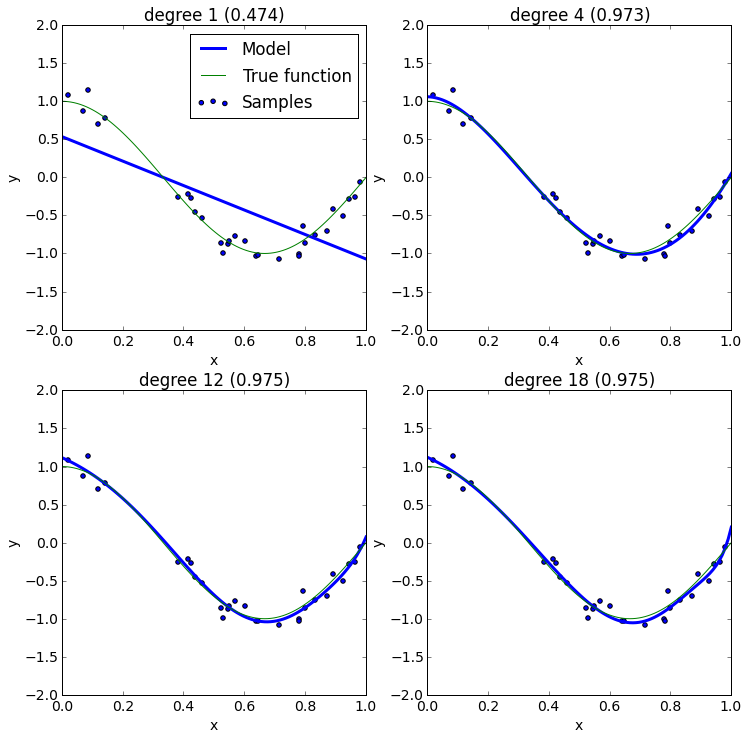

In [7]:
np.random.seed(0)

n_samples = 30
degrees = [1, 4, 12, 18]

true_fun = lambda X: np.cos(1.5 * np.pi * X)

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1 #adding noise

plt.figure(figsize=(12, 12))
for i in range(len(degrees)):
    ax = plt.subplot(2, 2, i+1)
    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    model = Ridge(alpha=1.0e-05)
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", model)])
    pipeline.fit(X[:, np.newaxis], y)
    pred = pipeline.predict(X[:, np.newaxis])
    
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model",lw=3)
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    if i == 0: plt.legend(loc="upper right")
    plt.title("degree %d (%.3f)" % (degrees[i],metrics.r2_score(y,pred)))
plt.show()

Observe how the complexity of the model is controlled for the larger polynomial degrees. Let's take a look at the optimal model parameter values $\theta$ for the polynomial model of degree 18 when $\lambda=1.0e-05$:

[-1.80778217 -4.84902519 -0.29399438  3.22464202  3.57734056  2.16120868
  0.69944175 -0.14891077 -0.5047579  -0.70603474 -0.98037361 -1.35714901
 -1.70631692 -1.81502643 -1.45645897 -0.43569633  1.38721214  4.09118918]


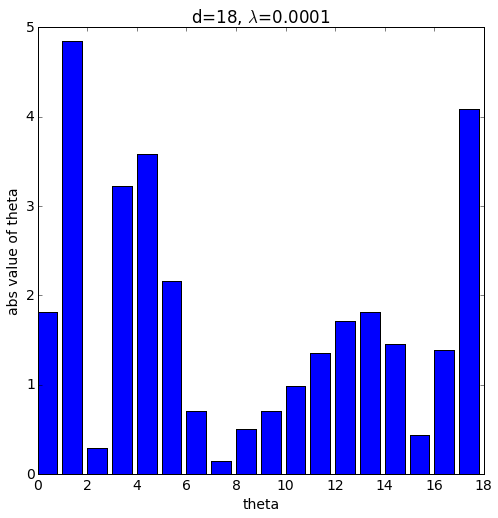

In [8]:
print model.coef_

plt.bar(range(len(model.coef_)),np.abs(model.coef_))
plt.xlabel('theta')
plt.ylabel('abs value of theta')
plt.title('d=18, $\lambda$=0.0001')
plt.show()

If we set $\lambda=0$, i.e. we remove the regularization term we get the overfitting again:

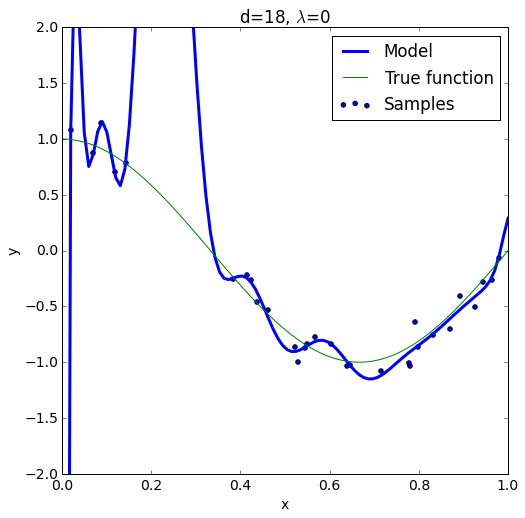

[  5.58343685e+03  -2.55833658e+05   6.26708970e+06  -9.41461365e+07
   9.37256511e+08  -6.50870789e+09   3.26997233e+10  -1.21996810e+11
   3.44132746e+11  -7.42196837e+11   1.22985173e+12  -1.56353761e+12
   1.51195822e+12  -1.09225383e+12   5.70827538e+11  -2.03851789e+11
   4.45080797e+10  -4.48157697e+09]


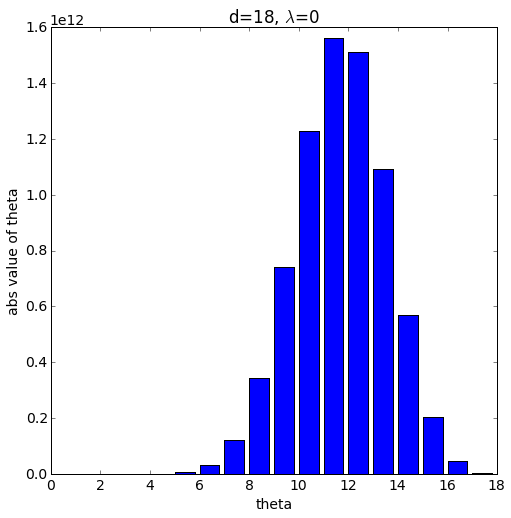

In [9]:
model = Ridge(alpha=0.0)
polynomial_features = PolynomialFeatures(degree=18,include_bias=False)
pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", model)])
pipeline.fit(X[:, np.newaxis], y)
pred = pipeline.predict(X[:, np.newaxis])
    
X_test = np.linspace(0, 1, 100)
plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model",lw=3)
plt.plot(X_test, true_fun(X_test), label="True function")
plt.scatter(X, y, label="Samples")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.legend(loc="upper right")
plt.title('d=18, $\lambda$=0')
plt.show()

print model.coef_

plt.bar(range(len(model.coef_)),np.abs(model.coef_))
plt.xlabel('theta')
plt.ylabel('abs value of theta')
plt.title('d=18, $\lambda$=0')
plt.show()

We can see that the values for $\theta$ are much larger now. This made it possible to fit more complex models that are able to fit the noise as well. Regularization is thus closely related to the nature of the noise in the data set.

Regularization is also related to the relative size of the dataset. Data sets with many features and few samples are common in machine learning. Regularization helps significantly to deal with sparse high-dimensional data sets. When we discuss support vector machines we see many examples of this.

For now we have chosen $\lambda=1.0e-05$ as a good regulator. Let's consider other values for $\lambda$ and see how they affect the model parameters and the fit.

In [10]:
n_lambda = 40
lambdas = np.logspace(-6, -10, n_lambda)
print lambdas

[  1.00000000e-06   7.89652287e-07   6.23550734e-07   4.92388263e-07
   3.88815518e-07   3.07029063e-07   2.42446202e-07   1.91448198e-07
   1.51177507e-07   1.19377664e-07   9.42668455e-08   7.44380301e-08
   5.87801607e-08   4.64158883e-08   3.66524124e-08   2.89426612e-08
   2.28546386e-08   1.80472177e-08   1.42510267e-08   1.12533558e-08
   8.88623816e-09   7.01703829e-09   5.54102033e-09   4.37547938e-09
   3.45510729e-09   2.72833338e-09   2.15443469e-09   1.70125428e-09
   1.34339933e-09   1.06081836e-09   8.37677640e-10   6.61474064e-10
   5.22334507e-10   4.12462638e-10   3.25702066e-10   2.57191381e-10
   2.03091762e-10   1.60371874e-10   1.26638017e-10   1.00000000e-10]


Now we fit the different Ridge models (with different values for $\lambda$) to the data and plot the optimal values for $\theta$ against $\lambda$. Each model parameter $\theta_j$ is represented by a different color. 

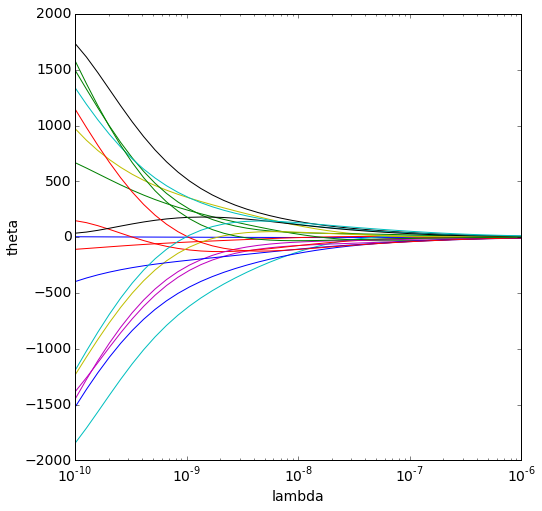

In [11]:
polynomial_features = PolynomialFeatures(degree=18,include_bias=False)

coefs = []
for l in lambdas:
    model.set_params(alpha=l)
    Xpoly = polynomial_features.fit_transform(X[:, np.newaxis])
    model.fit(Xpoly, y)
    coefs.append(model.coef_)
    
ax = plt.gca()
ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])
ax.plot(lambdas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('theta')
plt.show()    

For regularized logistic regression we reconsider the artificial data set we created above and fit a regularized logistic regression model to the data augmented with polynomial features of degree 7. We use the **LogisticRegression** object from scikit-learn that is in fact already an implementation of regularized logistic regression controlled by the function parameter $C$. However in the implementation $C$ = $1/\lambda$ and can be seen as the cost paid for a misclassification. Larger values for $C$ will allow for more complex models. This is why for the example above we set $C$=10000 to allow for maximum model complexity, which mimics unregularized logistic regression.

In the example shown below we decrease $C$ to 0.1, i.e. we lower the complexity of the model:

0.87


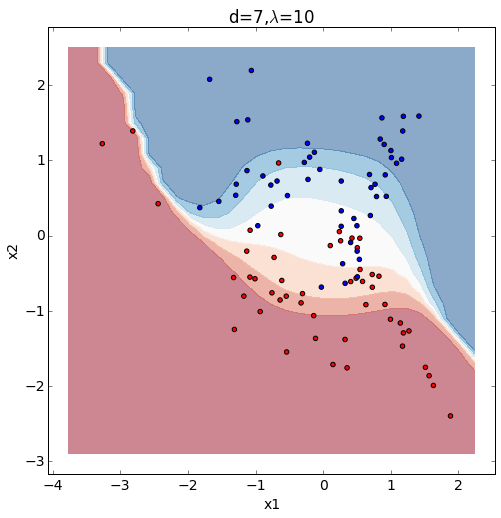

In [12]:
(X,Y)=ds.make_classification(n_samples=100,n_features=2,n_redundant=0,random_state=8)
X = StandardScaler().fit_transform(X)

clf = LogisticRegression(C=0.1,penalty='l2')
polynomial_features = PolynomialFeatures(degree=7)
model = Pipeline([("polynomial_features", polynomial_features),
                         ("logistic_regression", clf)])

model.fit(X,Y)
score = model.score(X, Y)
print score

plot_decision_boundary(model,X,Y)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('d=7,$\lambda$=10')
plt.show()

This does indeed control model complexity much better. We can see how the model does not try to fit the noise anymore.

We now have a means to control the complexity of the model learned from the train set by setting the value of a hyperparameter that controls the balance between train set accuracy and model complexity. 

We want to find the value for this hyperparameter that allows for training a model that performs best on unseen external data. We can (or should) thus apply cross-validation to compute the optimal value for the hyperparameter. 

In the following we will use an artificial data set with 5000 features of which only two are actually informative (these are the features that are useful for the model), 285 are redundant (these contain similar information as the informative features) and the others are irrelevant for the two-class classification tasks. The data set contains 1000 samples:

In [13]:
from sklearn.datasets import make_classification

(X,y) = make_classification(
n_samples=1000,
n_features=5000,
n_classes=2,
n_informative=2,
n_redundant=285,
n_repeated=5,
class_sep=0.4,
n_clusters_per_class=2,
shift=uniform(0, 100),
scale=None,
random_state=1
)
X = (X - X.mean()) / (X.max() - X.min())

#print X
#print y

We will try to separate the classes using a regularized logistic regression algorithm. First we optimize the parameter $\lambda$ on the train set using the *KFold* function: 

In [14]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression

search_space = np.logspace(-10, 10, 10, base=2)

n_folds = 10
kf = KFold(len(X), n_folds=n_folds,shuffle=True,random_state=1)

for C in search_space:
    model = LogisticRegression(C=C,fit_intercept=True)
    score_test_fold = 0.0
    for train, test in kf:
        model.fit(X[train], y[train])
        pred = model.score(X[test],y[test])
        score_test_fold += pred
    score_test_fold /= n_folds
    print "C=%f accuracy=%.3f" % (C,score_test_fold) 

C=0.000977 accuracy=0.483
C=0.004557 accuracy=0.490
C=0.021262 accuracy=0.591
C=0.099213 accuracy=0.660
C=0.462937 accuracy=0.670
C=2.160119 accuracy=0.674
C=10.079368 accuracy=0.668
C=47.031504 accuracy=0.636
C=219.454460 accuracy=0.610
C=1024.000000 accuracy=0.596


We see that the CV performance is best for $C=2.16$. In this case the average accuracy on the validation sets is 67.4%. However, we cannot consider this accuracy as a performance evaluation of the model with $C=2.16$. To estimate the performance on unseen external data we have to use the test set: 

In [15]:
n_folds = 3

model_performance = 0.0
kf_upper = KFold(len(X), n_folds=n_folds,shuffle=True,random_state=1)
for j, (train_upper, test_upper) in enumerate(kf_upper):
    X_upper = X[train_upper]
    y_upper = y[train_upper]
    kf = KFold(len(X_upper), n_folds=n_folds,shuffle=True,random_state=1)
    best_C=-1
    best_accuracy=0
    for C in search_space:
        model = LogisticRegression(C=C,fit_intercept=True)
        score_test_fold = 0.0
        for i, (train, test) in enumerate(kf):
            model.fit(X_upper[train], y_upper[train])
            pred = model.score(X_upper[test],y_upper[test])
            score_test_fold += pred
        score_test_fold /= n_folds
        print "Fold_upper=%i C=%f cv-accuracy=%.3f" % (j,C,score_test_fold) 
        if score_test_fold > best_accuracy:
            best_accuracy = score_test_fold
            best_C = C
    print "Fold_upper %i best C=%f" % (j,best_C)
    model = LogisticRegression(C=best_C,fit_intercept=True)
    model.fit(X_upper, y_upper)
    pred = model.score(X[test_upper],y[test_upper])
    print "Fold upper %i test set accuracy=%f" % (j,pred)
    model_performance += pred
model_performance /= n_folds
print "Model performance=%f" % model_performance

Fold_upper=0 C=0.000977 cv-accuracy=0.536
Fold_upper=0 C=0.004557 cv-accuracy=0.536
Fold_upper=0 C=0.021262 cv-accuracy=0.550
Fold_upper=0 C=0.099213 cv-accuracy=0.584
Fold_upper=0 C=0.462937 cv-accuracy=0.637
Fold_upper=0 C=2.160119 cv-accuracy=0.646
Fold_upper=0 C=10.079368 cv-accuracy=0.649
Fold_upper=0 C=47.031504 cv-accuracy=0.632
Fold_upper=0 C=219.454460 cv-accuracy=0.619
Fold_upper=0 C=1024.000000 cv-accuracy=0.614
Fold_upper 0 best C=10.079368
Fold upper 0 test set accuracy=0.655689
Fold_upper=1 C=0.000977 cv-accuracy=0.486
Fold_upper=1 C=0.004557 cv-accuracy=0.486
Fold_upper=1 C=0.021262 cv-accuracy=0.493
Fold_upper=1 C=0.099213 cv-accuracy=0.550
Fold_upper=1 C=0.462937 cv-accuracy=0.631
Fold_upper=1 C=2.160119 cv-accuracy=0.660
Fold_upper=1 C=10.079368 cv-accuracy=0.657
Fold_upper=1 C=47.031504 cv-accuracy=0.636
Fold_upper=1 C=219.454460 cv-accuracy=0.622
Fold_upper=1 C=1024.000000 cv-accuracy=0.613
Fold_upper 1 best C=2.160119
Fold upper 1 test set accuracy=0.663664
Fold_up

This is what we call nested-CV were one cross-validation loop creates train and test sets (*kf_upper*) and the other loop (*kf*) creates train and validation sets.

Scikit-learn has a function *GridSearchCV* that can help significantly with model selection. 
It exhaustively considers all parameter combinations for a given **search space**. Here we see an example of using *GridSeachCV* for the example shown above:

In [16]:
from sklearn import grid_search

n_folds = 3

search_space = {'C':np.logspace(-10, 10, 10, base=2)}

model_performance = 0.0
kf_upper = KFold(len(X), n_folds=n_folds,shuffle=True,random_state=1)
for j, (train_upper, test_upper) in enumerate(kf_upper):
    X_upper = X[train_upper]
    y_upper = y[train_upper]
    model = grid_search.GridSearchCV(LogisticRegression(fit_intercept=True), search_space,cv=n_folds)
    model.fit(X_upper,y_upper)
    print "Fold_upper %i best C=%f" % (j,model.best_estimator_.C)
    pred = model.best_estimator_.score(X[test_upper],y[test_upper])
    print "Fold upper %i test set accuracy=%f" % (j,pred)
    model_performance += pred
model_performance /= n_folds
print "Model performance=%f" % model_performance

Fold_upper 0 best C=2.160119
Fold upper 0 test set accuracy=0.670659
Fold_upper 1 best C=2.160119
Fold upper 1 test set accuracy=0.663664
Fold_upper 2 best C=0.462937
Fold upper 2 test set accuracy=0.648649
Model performance=0.660990
